In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/short-term-paper-4/sample_submission.csv
/kaggle/input/short-term-paper-4/train.csv
/kaggle/input/short-term-paper-4/test.csv


In [2]:
train_df = pd.read_csv("../input/short-term-paper-4/train.csv")
test_df = pd.read_csv("../input/short-term-paper-4/test.csv")
df_sample=pd.read_csv("../input/short-term-paper-4/sample_submission.csv")

In [3]:
print(train_df.describe)

<bound method NDFrame.describe of           id   age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0          0  40.0       155.0        45.0       63.0             1.2   
1          1  60.0       170.0        75.0       89.0             0.8   
2          2  45.0       160.0        55.0       70.0             1.2   
3          3  55.0       165.0        70.0       88.0             1.0   
4          4  40.0       160.0        50.0       70.0             1.0   
...      ...   ...         ...         ...        ...             ...   
14995  14995  60.0       170.0        75.0       90.0             1.2   
14996  14996  40.0       175.0        80.0       95.0             0.9   
14997  14997  45.0       160.0        75.0       89.0             0.9   
14998  14998  40.0       155.0        60.0       85.5             1.5   
14999  14999  25.0       170.0        60.0       78.0             1.2   

       eyesight(right)  hearing(left)  hearing(right)  systolic  ...   HDL  \
0          

In [4]:
# 2. Exploratory Data Analysis
def analyze_data(df, title="Dataset Analysis"):
    print(f"\n{title}")
    print("\nBasic Information:")
    print(df.info())
    
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    if 'smoking' in df.columns:
        print("\nTarget Distribution:")
        print(df['smoking'].value_counts(normalize=True))


In [5]:
analyze_data(train_df, "Training Data Analysis")
analyze_data(test_df, "Test Data Analysis")


Training Data Analysis

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float

In [6]:
# 3. Feature Engineering
def create_features(df):
    # Copy dataframe to avoid modifying original
    df = df.copy()
    
    # BMI calculation
    df['BMI'] = df['weight(kg)'] / ((df['height(cm)']/100) ** 2)
    
    # Blood pressure categories
    df['bp_category'] = pd.cut(df['systolic'], 
                              bins=[0, 120, 140, 180, float('inf')],
                              labels=['normal', 'pre_hypertensive', 'hypertensive_1', 'hypertensive_2'])
    
    # Age categories
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 30, 45, 60, float('inf')],
                            labels=['young', 'middle', 'senior', 'elderly'])
    
    # Health ratios
    df['cholesterol_hdl_ratio'] = df['Cholesterol'] / df['HDL']
    df['ldl_hdl_ratio'] = df['LDL'] / df['HDL']
    df['ast_alt_ratio'] = df['AST'] / df['ALT']
    
    # Blood pressure difference
    df['bp_difference'] = df['systolic'] - df['relaxation']
    
    # Vision asymmetry
    df['vision_asymmetry'] = abs(df['eyesight(left)'] - df['eyesight(right)'])
    
    return df


In [7]:
# Apply feature engineering
print("\nApplying feature engineering...")
train_df = create_features(train_df)
test_df = create_features(test_df)


Applying feature engineering...


In [8]:
# 4. Data Preprocessing
def preprocess_data(train_df, test_df, target_col='smoking'):
    # Separate features and target
    X = train_df.drop([target_col, 'id', 'bp_category', 'age_group'], axis=1)
    y = train_df[target_col]
    X_test = test_df.drop(['id', 'bp_category', 'age_group'], axis=1)
    
    # Get categorical columns
    cat_cols = X.select_dtypes(include=['object']).columns
    
    # Convert categorical variables
    X = pd.get_dummies(X, columns=cat_cols)
    X_test = pd.get_dummies(X_test, columns=cat_cols)
    
    # Ensure train and test have same columns
    for col in X.columns:
        if col not in X_test.columns:
            X_test[col] = 0
    X_test = X_test[X.columns]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)
    
    return X_scaled, y, X_test_scaled, X.columns



In [9]:
X_scaled, y, X_test_scaled, feature_names = preprocess_data(train_df, test_df)


In [10]:
# 5. Model Development and Evaluation
def train_and_evaluate_models(X, y, feature_names):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42)
    }
    
    best_score = 0
    best_model = None
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        # Calculate metrics
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
        
        print(f"ROC-AUC Score: {roc_auc:.4f}")
        print(f"Cross-validation ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Update best model if necessary
        if roc_auc > best_score:
            best_score = roc_auc
            best_model = model
        
        # Feature importance for Random Forest and XGBoost
        if name in ['Random Forest', 'XGBoost']:
            feature_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
            plt.title(f'Top 15 Most Important Features - {name}')
            plt.tight_layout()
            plt.show()
    
    return best_model



Training Logistic Regression...
ROC-AUC Score: 0.8658
Cross-validation ROC-AUC: 0.8689 (+/- 0.0134)

Training Random Forest...
ROC-AUC Score: 0.8743
Cross-validation ROC-AUC: 0.8784 (+/- 0.0141)


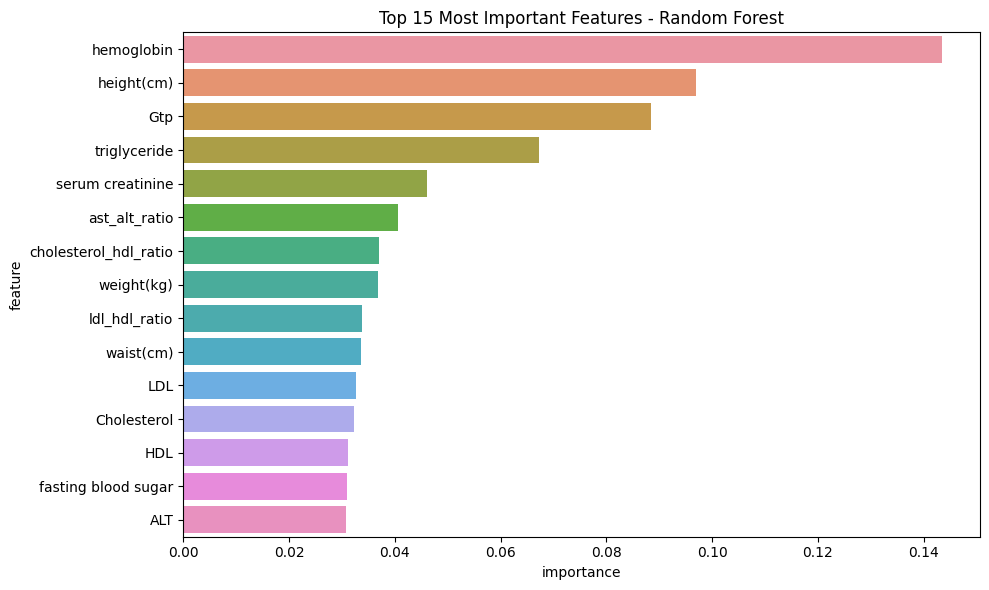


Training XGBoost...
ROC-AUC Score: 0.8784
Cross-validation ROC-AUC: 0.8782 (+/- 0.0167)


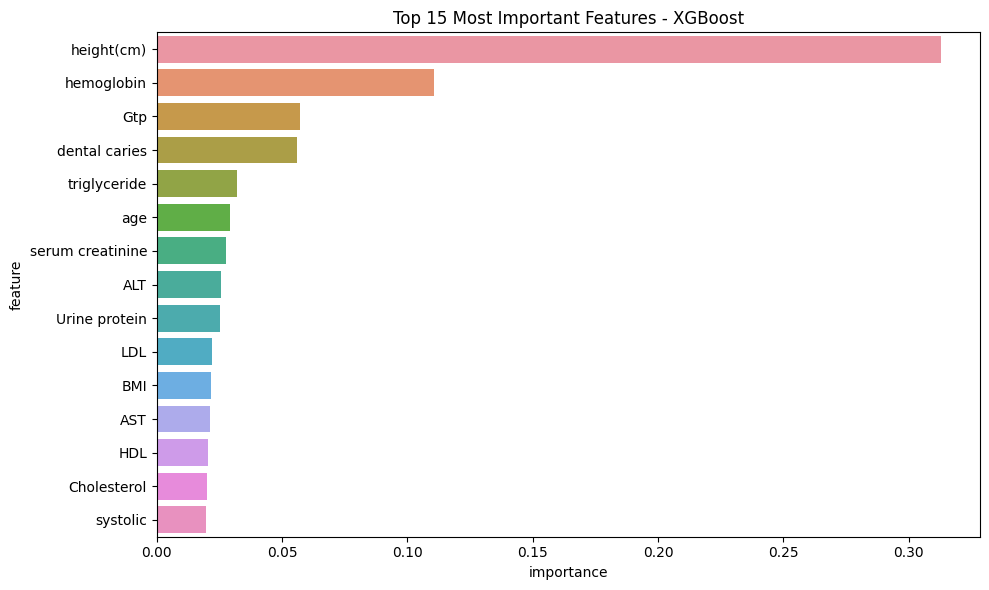

In [11]:
# Train and evaluate modelsa
best_model = train_and_evaluate_models(X_scaled, y, feature_names)


In [12]:
# 6. Make Predictions on Test Set
test_predictions = best_model.predict_proba(X_test_scaled)[:, 1]


In [13]:
# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'smoking': test_predictions
})
submission.to_csv('submission.csv', index=False)
print("\nPredictions completed and saved to 'submission.csv'")



Predictions completed and saved to 'submission.csv'


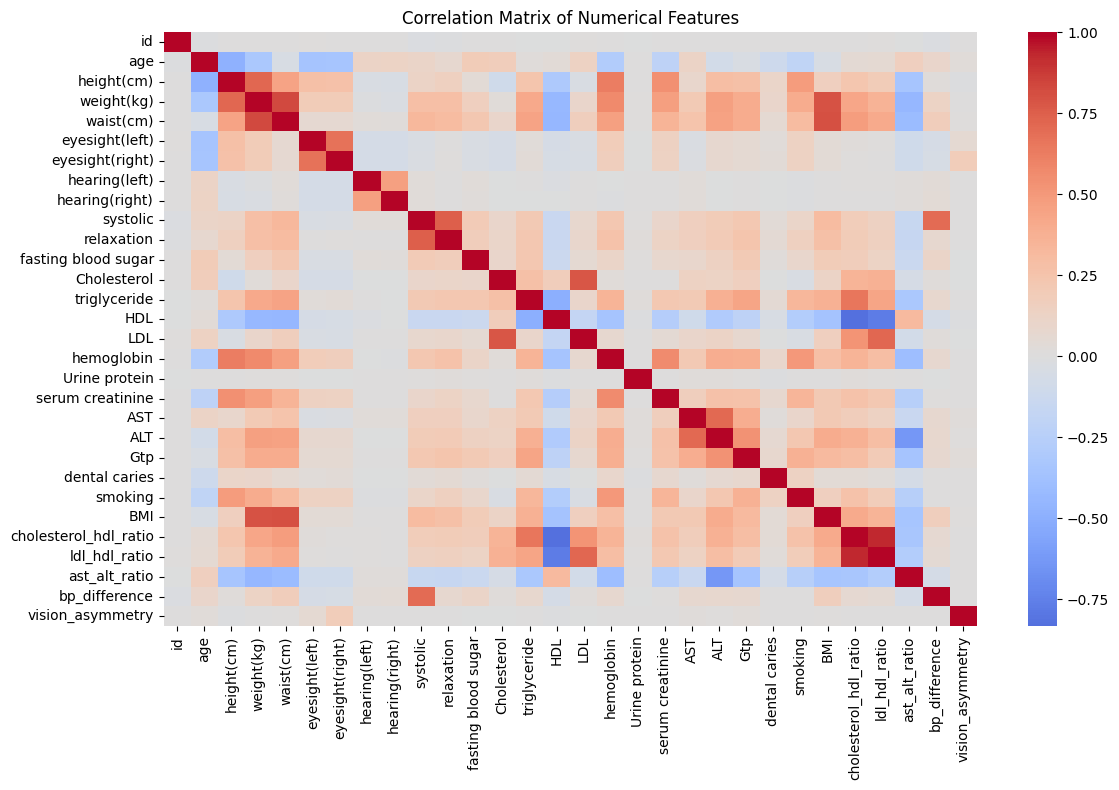

In [14]:
# 7. Additional Analysis

numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = train_df[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()


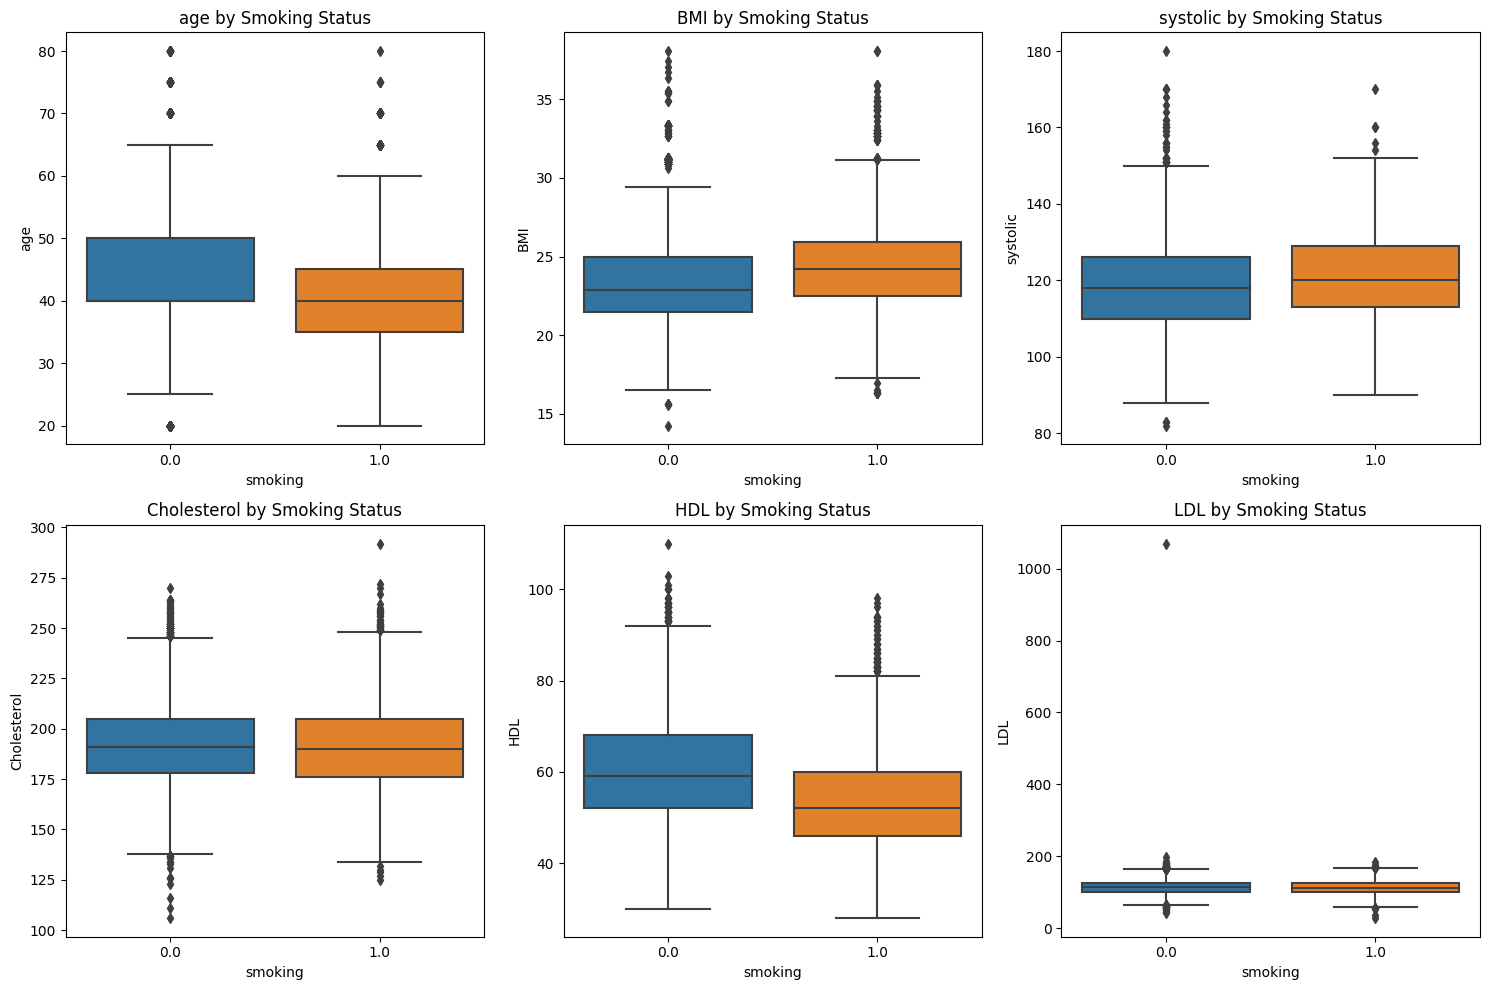

In [15]:
# Distribution of key features by smoking status
key_features = ['age', 'BMI', 'systolic', 'Cholesterol', 'HDL', 'LDL']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    sns.boxplot(x='smoking', y=feature, data=train_df, ax=axes[idx])
    axes[idx].set_title(f'{feature} by Smoking Status')

plt.tight_layout()
plt.show()